# EDA PORTION FOR ASSIGNMENT 2

# Task
Given the review text of a beer, see if we can predict its rating

In [1]:
###Loading up necessary libraries 

In [2]:
import gzip
from collections import defaultdict
import math
import scipy.optimize
import numpy
import string
import random
from sklearn import linear_model
import pandas as pd
import seaborn as sns
import numpy as np

from nltk.sentiment.vader import SentimentIntensityAnalyzer 
analyser = SentimentIntensityAnalyzer()

from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS

import matplotlib.pyplot as plt

In [3]:
def parse(f):
    for l in gzip.open(f):
        yield eval(l)

Loading up the beer data into 'beer_data' pandas DataFrame

In [4]:
dataset = list(parse("ratebeer.json.gz"))
beer_data = pd.DataFrame(dataset)
beer_data

,beer/name,beer/beerId,beer/brewerId,beer/ABV,beer/style,review/appearance,review/aroma,review/palate,review/taste,review/overall,review/time,review/profileName,review/text
0,John Harvards Simcoe IPA,63836,8481,5.4,India Pale Ale &#40;IPA&#41;,4/5,6/10,3/5,6/10,13/20,1157587200,hopdog,"On tap at the Springfield, PA location. Poured..."
1,John Harvards Simcoe IPA,63836,8481,5.4,India Pale Ale &#40;IPA&#41;,4/5,6/10,4/5,7/10,13/20,1157241600,TomDecapolis,On tap at the John Harvards in Springfield PA....
2,John Harvards Cristal Pilsner,71716,8481,5,Bohemian Pilsener,4/5,5/10,3/5,6/10,14/20,958694400,PhillyBeer2112,"UPDATED: FEB 19, 2003 Springfield, PA. I've ne..."
3,John Harvards Fancy Lawnmower Beer,64125,8481,5.4,Klsch,2/5,4/10,2/5,4/10,8/20,1157587200,TomDecapolis,On tap the Springfield PA location billed as t...
4,John Harvards Fancy Lawnmower Beer,64125,8481,5.4,Klsch,2/5,4/10,2/5,4/10,8/20,1157587200,hopdog,"On tap at the Springfield, PA location. Poured..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2924159,Oakhill Yeoman 1767 Strong Ale,5677,1028,5,Premium Bitter/ESB,4/5,5/10,3/5,6/10,12/20,1074816000,imdownthepub,"Cask conditioned at The Wild Goose, Combeignte..."
2924160,Oakhill Yeoman 1767 Strong Ale,5677,1028,5,Premium Bitter/ESB,4/5,4/10,3/5,6/10,13/20,1050796800,SilkTork,The original Oakhill Brewery was formed in 176...
2924161,Oakhill Yeoman 1767 Strong Ale,5677,1028,5,Premium Bitter/ESB,3/5,5/10,2/5,5/10,10/20,1016409600,omhper,Sampled cask conditioned. Amber coloured. Frui...
2924162,Oakhill Yeoman 1767 Strong Ale,5677,1028,5,Premium Bitter/ESB,4/5,8/10,4/5,7/10,15/20,1000252800,Bov,


Deleting the last row since its the only one that has NaNs. Check if any NaNs left

In [5]:
beer_data = beer_data[:-1]
#beer_data.isna().sum().sum()

In [6]:
###These are the columns of the beer_data
beer_data.dtypes

beer/name             object
beer/beerId           object
beer/brewerId         object
beer/ABV              object
beer/style            object
review/appearance     object
review/aroma          object
review/palate         object
review/taste          object
review/overall        object
review/time           object
review/profileName    object
review/text           object
dtype: object

Finding top 10 most occurred beers in the dataset

In [7]:
most_occurred_10_beers = beer_data.value_counts(subset='beer/name').head(10)
for i, entry in enumerate(most_occurred_10_beers):
    print("Beer name:", most_occurred_10_beers.index[i], "( with the occurrence of", most_occurred_10_beers[i], ")")

Beer name: Guinness Draught ( with the occurrence of 3696 )
Beer name: Pabst Blue Ribbon ( with the occurrence of 3662 )
Beer name: Dogfish Head 90 Minute Imperial IPA ( with the occurrence of 3230 )
Beer name: Budweiser ( with the occurrence of 3126 )
Beer name: Sierra Nevada Pale Ale &#40;Bottle&#41; ( with the occurrence of 3119 )
Beer name: Samuel Adams Boston Lager ( with the occurrence of 3110 )
Beer name: Chimay Bleue &#40;Blue&#41; / Grande Rserve ( with the occurrence of 3056 )
Beer name: North Coast Old Rasputin Russian Imperial Stout ( with the occurrence of 2904 )
Beer name: Stone Arrogant Bastard Ale ( with the occurrence of 2872 )
Beer name: Orval ( with the occurrence of 2813 )


In [ ]:
###   We could possible draw the most occured beers with their ratings or something

#to_plot = pd.DataFrame(beer_data.value_counts(subset='beer/name').head(3))
#sns.barplot(x=to_plot.index, y=to_plot[0])

Collect all the data from the most occured beers

In [8]:
most_occurred_beers = beer_data.loc[beer_data['beer/name'].isin(most_occurred_10_beers.index)].reset_index(drop=True)
most_occurred_beers

,beer/name,beer/beerId,beer/brewerId,beer/ABV,beer/style,review/appearance,review/aroma,review/palate,review/taste,review/overall,review/time,review/profileName,review/text
0,Chimay Bleue &#40;Blue&#41; / Grande Rserve,53,12,9,Belgian Strong Ale,5/5,9/10,5/5,10/10,19/20,1235520000,BanjoDude,"From the corked bottle... Pours a rich, creamy..."
1,Chimay Bleue &#40;Blue&#41; / Grande Rserve,53,12,9,Belgian Strong Ale,3/5,4/10,3/5,5/10,8/20,1235433600,Strangebrewer,bottle. Poured dark brown with sediment and sm...
2,Chimay Bleue &#40;Blue&#41; / Grande Rserve,53,12,9,Belgian Strong Ale,4/5,8/10,5/5,8/10,16/20,1235260800,fidelis83,Pours very dark brown with lots of tiny tan pa...
3,Chimay Bleue &#40;Blue&#41; / Grande Rserve,53,12,9,Belgian Strong Ale,5/5,10/10,4/5,10/10,19/20,1235260800,thefrutigers,bottle 11.20 oz.: Large light brown head. Dee...
4,Chimay Bleue &#40;Blue&#41; / Grande Rserve,53,12,9,Belgian Strong Ale,5/5,9/10,5/5,10/10,19/20,1235174400,Nebulor,Aromas of caramel and molasses with other malt...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31583,Dogfish Head 90 Minute Imperial IPA,10569,198,9,Imperial/Double IPA,4/5,8/10,4/5,8/10,15/20,1318636800,Neeskens,Slighly hazy light amber with a off-white to l...
31584,Dogfish Head 90 Minute Imperial IPA,10569,198,9,Imperial/Double IPA,3/5,7/10,2/5,8/10,15/20,1318550400,LakeHigh,This is a nice middle of the road I.P.A.. By ...
31585,Dogfish Head 90 Minute Imperial IPA,10569,198,9,Imperial/Double IPA,4/5,7/10,3/5,7/10,12/20,1318550400,Chudwick,Draft in a Trappist glass - pours clear golden...
31586,Dogfish Head 90 Minute Imperial IPA,10569,198,9,Imperial/Double IPA,4/5,5/10,3/5,5/10,12/20,1318377600,HardingG,"UPDATED: NOV 3, 2011 Not bad. Perhaps too pine..."


In [10]:
most_occurred_beers.describe()

,beer/name,beer/beerId,beer/brewerId,beer/ABV,beer/style,review/appearance,review/aroma,review/palate,review/taste,review/overall,review/time,review/profileName,review/text
count,31588,31588,31588,31588,31588,31588,31588,31588,31588,31588,31588,31588,31588
unique,10,10,11,7,9,5,10,5,10,20,3994,9396,29551
top,Guinness Draught,1267,13,9,Pale Lager,4/5,8/10,4/5,8/10,17/20,1172793600,MrBunn,
freq,3696,3696,3696,9190,6788,12536,7459,12630,7849,4503,28,11,191


### Now we begin the sentiment analysis

In [12]:
def get_sentiments(input_list):
    
    output = {}

    for sentence in input_list:
        ss = analyser.polarity_scores(sentence)
        ss['sentence'] = sentence
        for key in ss:
            if key in output:
                output[key] += [ss[key]]
            else:
                output[key] = [ss[key]]

    return pd.DataFrame(output)

In [13]:
beer_data_reviews = list(beer_data['review/text'].values)
len(beer_data_reviews)

2924163

In [14]:
sentiments = get_sentiments(beer_data_reviews)

In [15]:
sentiments.head(10)

,neg,neu,pos,compound,sentence
0,0.044,0.909,0.047,0.0571,"On tap at the Springfield, PA location. Poured..."
1,0.044,0.956,0.000,-0.4549,On tap at the John Harvards in Springfield PA....
2,0.150,0.780,0.069,-0.6310,"UPDATED: FEB 19, 2003 Springfield, PA. I've ne..."
3,0.048,0.845,0.108,0.4779,On tap the Springfield PA location billed as t...
4,0.000,0.928,0.072,0.6249,"On tap at the Springfield, PA location. Poured..."
5,0.083,0.750,0.167,0.6977,"Springfield, PA location... Poured an opaque b..."
6,0.099,0.824,0.077,-0.2732,"On tap at the Springfield, PA location. Listed..."
7,0.000,0.792,0.208,0.8248,"Sampled @ the Springfield, PA location. Cand..."
8,0.000,1.000,0.000,0.0000,Springfield... Poured a hazy copper color with...
9,0.036,0.721,0.243,0.9682,"UPDATED: FEB 19, 2003 Springfield, PA. Darkish..."


In [16]:
#This line of code gets most negatively classified sentence
sentiments.sort_values(by='compound').iloc[0]['sentence']

'NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO. NO.'

In [17]:
#This line of code gets most positively classified sentence
sentiments.sort_values(by='compound').iloc[-1]['sentence']

'UPDATED: JAN 24, 2011 2006 Vintage\t3/01/2007:  Well, the Duck-Rabbit Barleywine tasted more like "Bandywine", but Ross redeemed himself one this one.  Apparently the bottle he sent me is approaching a year old and it was awesome right now...\tDuck-Rabbit Wee Heavy Scotch Style Ale pours a clear dark amber color.  It has an ample amount of carbonation, but it isnt over done.  Initially there is a small honey-colored head, but it quickly diminishes and leaves only a partial film.  This stuff \tlooks pretty thick; the bubbles rise slowly to the surface through the viscous beer...  The aroma is sweet, deeply malty and contains a complex blend of aged fruit, caramel/chocolate, and fine alcohol.  The flavor is rich, full, malty, and complex.  Flavors of aged dark fruit, something darker like caramel and/or chocolate, and reminants of subltle smoke blend into an amazing experience.  The alcohol is extremely well integrated into the overall flavor and barely noticeable.  The mouthfeel is thi

In [18]:
sentiments.describe()

,neg,neu,pos,compound
count,2.924163e+06,2.924163e+06,2.924163e+06,2.924163e+06
mean,4.936293e-02,7.873712e-01,1.615468e-01,4.863904e-01
std,6.103293e-02,1.116618e-01,1.027245e-01,4.800538e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,-9.994000e-01
25%,0.000000e+00,7.230000e-01,9.100000e-02,1.970000e-01
50%,3.500000e-02,7.930000e-01,1.540000e-01,6.705000e-01
75%,7.800000e-02,8.590000e-01,2.240000e-01,8.720000e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,9.999000e-01


<AxesSubplot:xlabel='compound', ylabel='Count'>

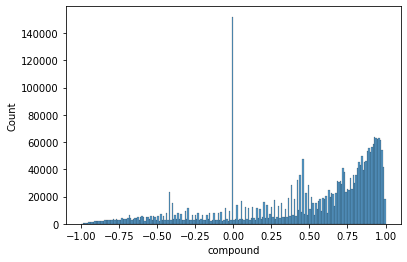

In [19]:
sns.histplot(x=sentiments['compound'])

In [20]:
### df is the original 'beer_data' dataframe with the sentiment scores appended for each review
df = pd.merge(beer_data, sentiments, left_on='review/text', right_on='sentence', how='inner').drop(columns=['sentence'])
df = df.drop_duplicates().reset_index(drop=True)
df

,beer/name,beer/beerId,beer/brewerId,beer/ABV,beer/style,review/appearance,review/aroma,review/palate,review/taste,review/overall,review/time,review/profileName,review/text,neg,neu,pos,compound
0,John Harvards Simcoe IPA,63836,8481,5.4,India Pale Ale &#40;IPA&#41;,4/5,6/10,3/5,6/10,13/20,1157587200,hopdog,"On tap at the Springfield, PA location. Poured...",0.044,0.909,0.047,0.0571
1,John Harvards Simcoe IPA,63836,8481,5.4,India Pale Ale &#40;IPA&#41;,4/5,6/10,4/5,7/10,13/20,1157241600,TomDecapolis,On tap at the John Harvards in Springfield PA....,0.044,0.956,0.000,-0.4549
2,John Harvards Cristal Pilsner,71716,8481,5,Bohemian Pilsener,4/5,5/10,3/5,6/10,14/20,958694400,PhillyBeer2112,"UPDATED: FEB 19, 2003 Springfield, PA. I've ne...",0.150,0.780,0.069,-0.6310
3,John Harvards Fancy Lawnmower Beer,64125,8481,5.4,Klsch,2/5,4/10,2/5,4/10,8/20,1157587200,TomDecapolis,On tap the Springfield PA location billed as t...,0.048,0.845,0.108,0.4779
4,John Harvards Fancy Lawnmower Beer,64125,8481,5.4,Klsch,2/5,4/10,2/5,4/10,8/20,1157587200,hopdog,"On tap at the Springfield, PA location. Poured...",0.000,0.928,0.072,0.6249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2924154,Oakhill Mendip Twister,12240,1028,6.3,Stout,2/5,5/10,2/5,5/10,8/20,1019433600,Kst,"Burnt suggar, molasses.Smells coffie. OK in sm...",0.000,0.705,0.295,0.4466
2924155,Oakhill Mendip Twister,12240,1028,6.3,Stout,3/5,7/10,3/5,7/10,15/20,1013731200,rauchbier,"Doesnt suggest it from the bottle label, but f...",0.083,0.872,0.046,-0.3919
2924156,Oakhill Yeoman 1767 Strong Ale,5677,1028,5,Premium Bitter/ESB,4/5,5/10,3/5,6/10,12/20,1074816000,imdownthepub,"Cask conditioned at The Wild Goose, Combeignte...",0.000,0.755,0.245,0.7962
2924157,Oakhill Yeoman 1767 Strong Ale,5677,1028,5,Premium Bitter/ESB,4/5,4/10,3/5,6/10,13/20,1050796800,SilkTork,The original Oakhill Brewery was formed in 176...,0.061,0.784,0.155,0.9403


In [21]:
given_scores = df['review/overall'].str.split('/').str[0].astype(int)
#x2 = df['review/overall'].str.split('/').str[1].astype(int)
fraction_scores = (given_scores / 20)

<AxesSubplot:xlabel='review/overall', ylabel='compound'>

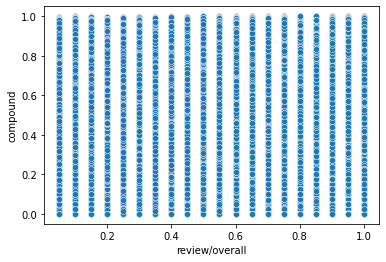

In [22]:
sns.scatterplot(data=df, y=np.abs(df['compound']), x=fraction_scores)

# TF-IDF

In [95]:
vectorizer = TfidfVectorizer()
punctuation = set(string.punctuation)

In [96]:
wordCount = defaultdict(int)
ratings_words = [""] * 5
entire_text = ""
useless_words = ["aroma", "flavor", "light"]
for i in range(len(df)):
    sentence = ''.join([c for c in df.iloc[i]['review/text'].lower() if not c in punctuation])
    entire_text += sentence
    if (fraction_scores[i] >= 0.8):
        for w in sentence.split():
            if w not in useless_words:
                wordCount[w] += 1
                ratings_words[0] += " " + w
    elif(fraction_scores[i] >= 0.6):
        for w in sentence.split():
            if w not in useless_words:
                wordCount[w] += 1
                ratings_words[1] += " " + w
    elif(fraction_scores[i] >= 0.4):
        for w in sentence.split():
            if w not in useless_words:
                wordCount[w] += 1
                ratings_words[2] += " " + w
    elif(fraction_scores[i] >= 0.2):
        for w in sentence.split():
            if w not in useless_words:
                wordCount[w] += 1
                ratings_words[3] += " " + w
    elif(fraction_scores[i] >= 0):
        for w in sentence.split():
            if w not in useless_words:
                wordCount[w] += 1
                ratings_words[4] += " " + w

KeyboardInterrupt: 

In [69]:
counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

(-0.5, 399.5, 199.5, -0.5)

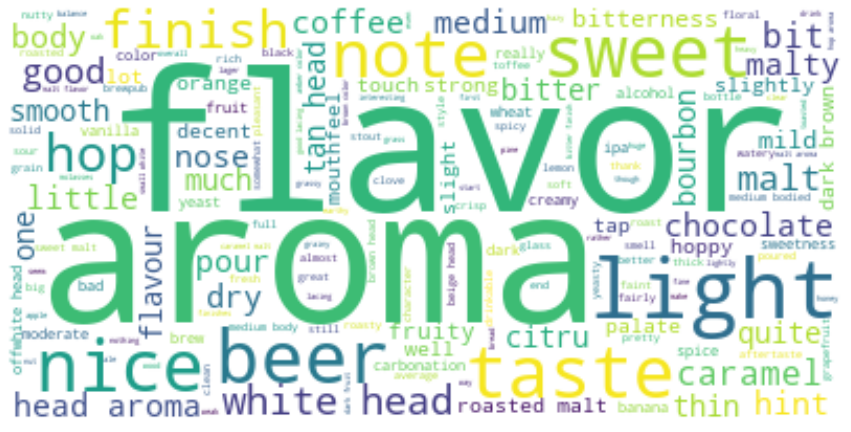

In [70]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(entire_text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

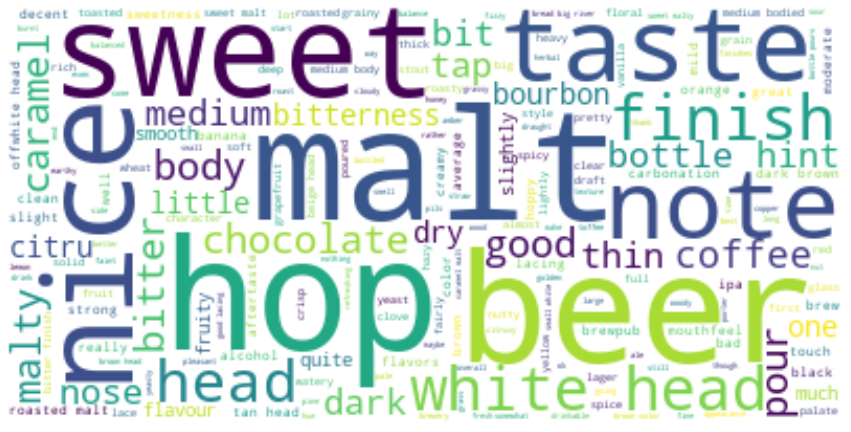

In [71]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(ratings_words[0])
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

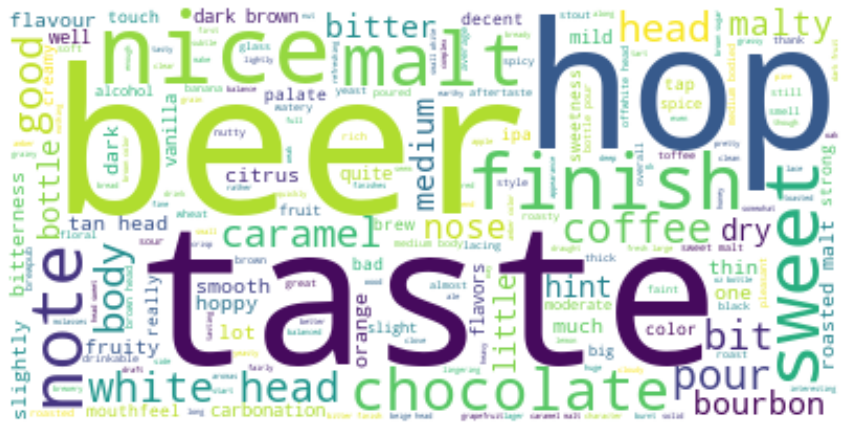

In [72]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(ratings_words[1])
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

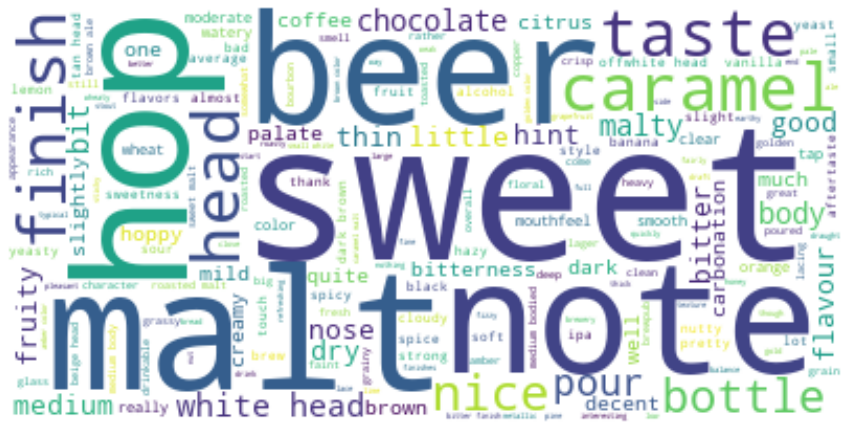

In [73]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(ratings_words[2])
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

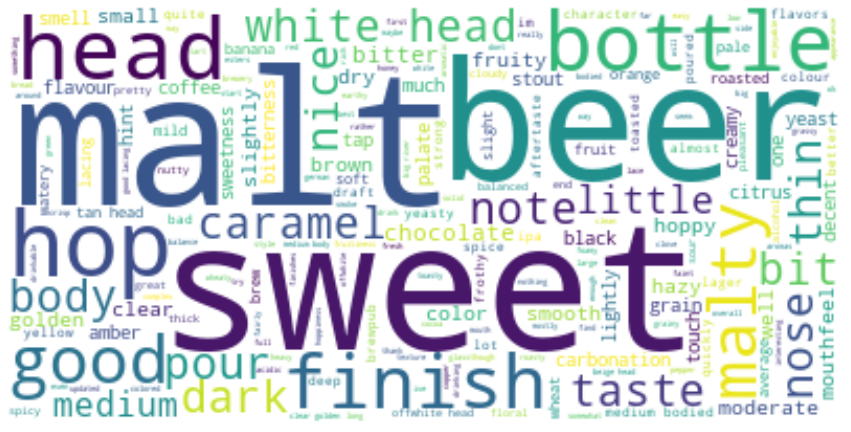

In [74]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(ratings_words[3])
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

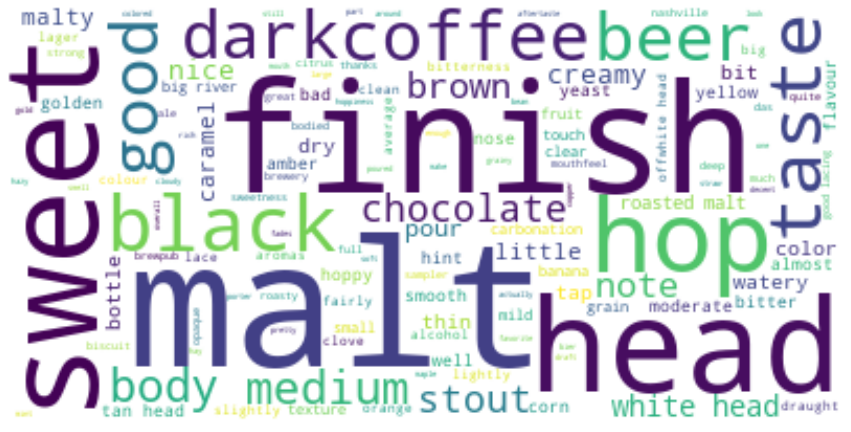

In [75]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(ratings_words[4])
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

In [37]:
Xtrain = vectorizer.fit_transform(beer_data_reviews)
Ytrain = []
for i in range(len(beers_data)):
    Ytrain.append(beers_data.iloc[i]['review/overall'])

KeyboardInterrupt: 